In [1]:
import matplotlib.pyplot as plt
import sacc
import numpy as np
import os

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def make_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [3]:
c = ['teal', 'powderblue', 'orange',  'cornflowerblue', 'tomato']
z = [0.25588604, 0.55455363, 0.91863365, 1.38232001, 2.]
def convert_to_z_labels(z):
    return ['$%0.2f < z < %0.2f$'%(z[i], z[i+1]) for i in range(len(z)-1)]
z_labels = convert_to_z_labels(z)
print(z_labels)
#z_labels = ['$0.30 < z < 0.55$','$0.55 < z < 0.80$','$0.80 < z < 1.05$','$1.05 < z < 2.0$']

['$0.26 < z < 0.55$', '$0.55 < z < 0.92$', '$0.92 < z < 1.38$', '$1.38 < z < 2.00$']


In [4]:
def plot_cl_ee(s, theory=None):
    
    plt.clf()
    fig, ax = plt.subplots(2, 2, figsize=(6, 6), sharey=True, sharex=True)
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    for dt in s.get_data_types():
        print(dt)
        if dt == 'galaxy_shear_cl_ee':
            for i in range(4):

                ell, cl, cov = s.get_ell_cl(dt,'source_%s'%i , 'source_%s'%i, return_cov = True)

                if i<2: j = 0 
                else: j = 1
                    
                if theory is not None:
                    ell_th, cl_th, cov_th = theory.get_ell_cl(dt,'source_%s'%i , 'source_%s'%i, return_cov = True)

                    ax[j][i%2].plot(ell_th, cl_th, ls = '-', lw = '1.5', color = c[i], label = 'Theory')
              
                ax[j][i%2].errorbar(ell, cl, np.sqrt(np.diag(cov)), fmt = '.', capsize=1.5, elinewidth=0.8, color = c[i], label = 'Measurements')
                ax[j][i%2].text(0.5, 0.88, z_labels[i], horizontalalignment='center',
                              verticalalignment='center', transform=ax[j][i%2].transAxes)#, fontsize=12)
                ax[j][i%2].set_xscale('log')
                ax[j][i%2].set_yscale('log')
                ax[j][i%2].set_ylim(10**(-11), 2*10**(-8))
                
                if i>1: 
                    ax[j][i%2].set_xlabel(r'$l$ ')
                if i%2<1:
                    ax[j][i%2].set_ylabel(r'$C_{EE} (l)$')

    ax[1][0].legend(frameon = False, loc = 'lower left')

    return fig

In [5]:
def plot_cl_ee_ratios(s, theory=None):
    
    plt.clf()
    fig, ax = plt.subplots(2, 2, figsize=(6, 6), sharey=True, sharex=True)
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    for dt in s.get_data_types():
        print(dt)
        if dt == 'galaxy_shear_cl_ee':
            for i in range(4):

                ell, cl, cov = s.get_ell_cl(dt,'source_%s'%i , 'source_%s'%i, return_cov = True)
                print(len(ell))
                ell_th, cl_th, cov_th = theory.get_ell_cl(dt,'source_%s'%i , 'source_%s'%i, return_cov = True)
                if i<2: j = 0 
                else: j = 1
                ax[j][i%2].errorbar(ell, cl/cl_th, np.sqrt(np.diag(cov))/cl_th, fmt = '.', capsize=1.5, elinewidth=0.8, color = c[i], label ='Data/Theory')
                #ax[j][i%2].plot(ell, cl/cl_th, ls = '-', lw = '1.5', color = c[i], )
                ax[j][i%2].text(0.5, 0.88, z_labels[i], horizontalalignment='center',
                              verticalalignment='center', transform=ax[j][i%2].transAxes)#, fontsize=12)
                ax[j][i%2].set_xscale('log')
                ax[j][i%2].axhline(y=1., color = 'k', ls = ':')
                if i>1: 
                    ax[j][i%2].set_xlabel(r'$l$ ')
                if i%2<1:
                    ax[j][i%2].set_ylabel(r'$C_{EE} (l) ratios$')

    ax[1][0].legend(frameon = False, loc = 'lower left')

    return fig

In [7]:
def get_mean(s, dt):
    dps = s.get_data_points(dt)
    mean = []
    for dp in dps:
        mean.append(dp.value)
    mean = np.array(mean)
    return mean

def compute_chi2(data, theory, dt):
    data_mean = get_mean(data, dt)
    theory_mean = get_mean(theory, dt)
    ind = theory.indices(dt)
    
    cov = theory.covariance.get_block(ind)
    #print(cov)
    invcov = np.linalg.inv(cov)
    #print(invcov)
    deltachi2 = np.dot(np.dot(data_mean-theory_mean, invcov), data_mean-theory_mean)
    ndf = len(data_mean)
    return deltachi2, ndf, cov


def corrmatrix(cov):
    cov = np.mat(cov)
    D = np.diag(np.sqrt(np.diag(cov)))
    d = np.linalg.inv(D)
    corr = d*cov*d
    return corr

def plot_cov(cov, size):
    
    ncov1 = len(cov)
    ncov2 = len(cov[0])
    
    corr = corrmatrix(cov)
    cov_vmin = np.min(corr)
    
    figsize1 = 1.22222222227*ncov1/size
    figsize2 = ncov2/size
    fig, ax = plt.subplots(1, 1, figsize=(figsize1, figsize2))
    im = ax.imshow(corr, interpolation='nearest',
                           aspect='auto', origin='lower', vmin=cov_vmin, vmax=1.)
    cbar = fig.colorbar(im)
    return fig

## With Shape Noise last run

In [10]:
dir = '../data_vectors/4sbins/'
file = 'summary_statistics_fourier.sacc' 
f = sacc.Sacc.load_fits(dir+file)
file = 'twopoint_theory_fourier.sacc'
t = sacc.Sacc.load_fits(dir+file)
make_directory(dir + 'plots/')
for dt in f.get_data_types():
        print(dt)
print ('----')
for dt in t.get_data_types():
        print(dt)     

galaxy_density_cl
galaxy_shearDensity_cl_e
galaxy_shear_cl_ee
----
galaxy_density_cl
galaxy_shearDensity_cl_e
galaxy_shear_cl_ee


deltachi = 240.6929519665869
ndf = 190


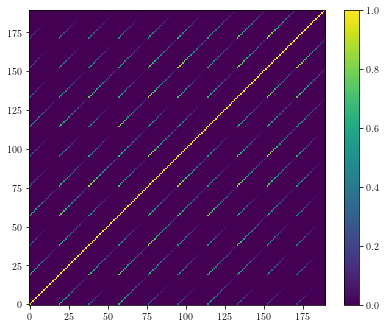

In [11]:
deltachi2, ndf, cov = compute_chi2(f, t, 'galaxy_shear_cl_ee')
print('deltachi =', deltachi2)
print('ndf =', ndf)
fig = plot_cov(cov, size = 35.)
plt.savefig(dir + 'plots/cov_cl_ee.png', dpi = 300)

galaxy_density_cl
galaxy_shearDensity_cl_e
galaxy_shear_cl_ee


<Figure size 432x288 with 0 Axes>

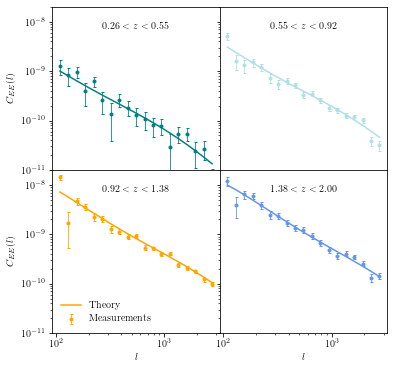

In [12]:
fig = plot_cl_ee(f, theory=t)
plt.savefig(dir + 'plots/cl_ee.png', dpi = 300)

galaxy_density_cl
galaxy_shearDensity_cl_e
galaxy_shear_cl_ee
19
19
19
19


<Figure size 432x288 with 0 Axes>

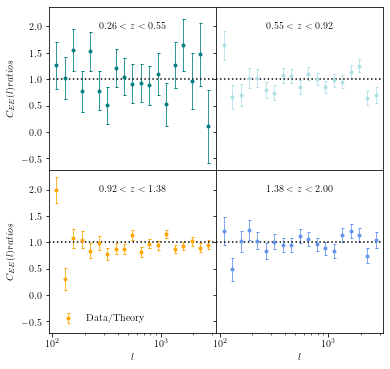

In [13]:
fig = plot_cl_ee_ratios(f, theory=t)
plt.savefig(dir + 'plots/cl_ee_ratios.png', dpi = 300)

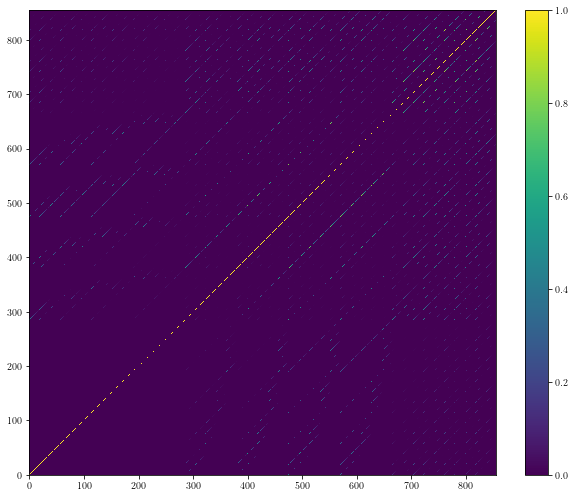

In [20]:
cov = f.covariance.covmat
fig = plot_cov(cov, size = 100.)
plt.savefig(dir + 'plots/cov_fourier_full.png', dpi = 300)

## No shape noise run

In [14]:
dir_no_sn = '../data_vectors/no_shape_noise_4sbins/'
file = 'summary_statistics_fourier.sacc' 
f_no_sn = sacc.Sacc.load_fits(dir_no_sn + file)
file = 'twopoint_theory_fourier.sacc'
t_no_sn = sacc.Sacc.load_fits(dir_no_sn + file)

make_directory(dir_no_sn + 'plots/')

deltachi = 49.12852965395483
ndf = 190


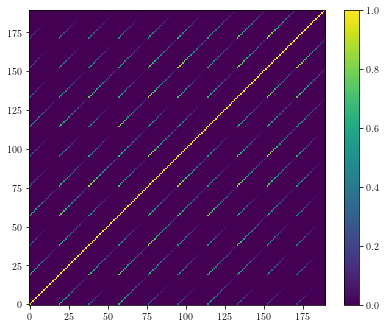

In [15]:
deltachi2, ndf, cov = compute_chi2(f_no_sn, t_no_sn, 'galaxy_shear_cl_ee')
print('deltachi =', deltachi2)
print('ndf =', ndf)
fig = plot_cov(cov, size = 35.)
plt.savefig(dir_no_sn + 'plots/cov_cl_ee.png', dpi = 300)

galaxy_density_cl
galaxy_shearDensity_cl_e
galaxy_shear_cl_ee


<Figure size 432x288 with 0 Axes>

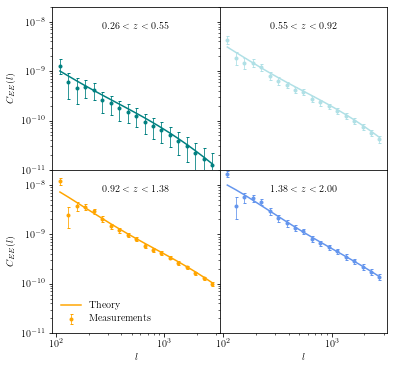

In [16]:
fig = plot_cl_ee(f_no_sn, theory=t_no_sn)
plt.savefig(dir_no_sn + 'plots/cl_ee.png', dpi = 300)

galaxy_density_cl
galaxy_shearDensity_cl_e
galaxy_shear_cl_ee
19
19
19
19


<Figure size 432x288 with 0 Axes>

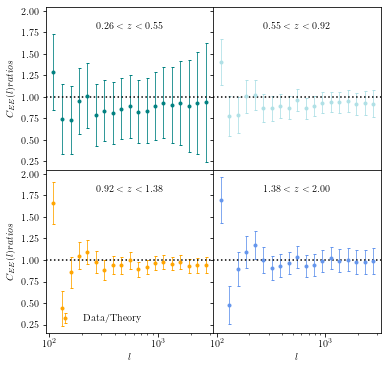

In [17]:
fig = plot_cl_ee_ratios(f_no_sn, theory=t_no_sn)
plt.savefig(dir_no_sn + 'plots/cl_ee_ratios.png', dpi = 300)

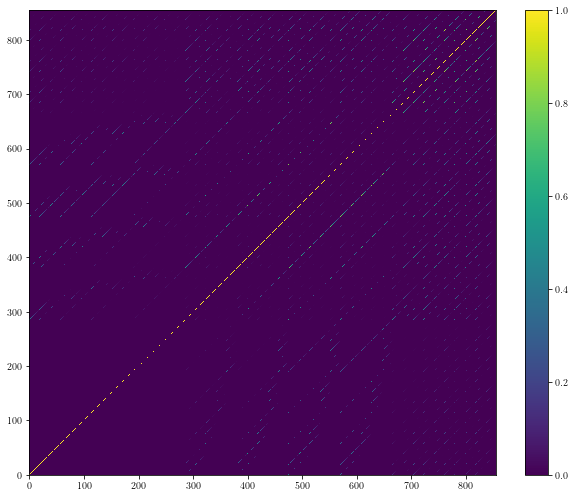

In [21]:
cov = f_no_sn.covariance.covmat
fig = plot_cov(cov, size = 100.)
plt.savefig(dir_no_sn + 'plots/cov_fourier_full.png', dpi = 300)